## **<span style="color:#023e8a;font-size:200%"><center> 🔥🔥EDA H&M🔥🔥</center></span>**

## **<span style="color:#023e8a;font-size:1000%"><center>EDA</center></span><span style="color:#023e8a;font-size:200%"><center>Exploratory Data Analysis. H&M</center></span>**

# **<a id="Content" style="color:#023e8a;">Table of Content</a>**
* [**<span style="color:#023e8a;">1. Dataset</span>**](#Dataset)  
* [**<span style="color:#023e8a;">2. Articles</span>**](#Articles)  
* [**<span style="color:#023e8a;">3. Customers</span>**](#Customers)  
* [**<span style="color:#023e8a;">4. Transactions</span>**](#Transactions)  
* [**<span style="color:#023e8a;">5. Images with description and price</span>**](#Images)  

## **<span style="color:#023e8a;">Intro</span>**

**<span style="color:#023e8a;">The competition is dedicated to the product recomendations (H&M)  </span>**

**<span style="color:#023e8a;">Here we have different kinds of data that help us to get good recomendations: </span>**



<center><h1>- Data Exploration -</h1></center>

>  🛍️ **Competition Goal:** For each customer within the training data we need to predict up to 12 products that the customer will buy in the next 7-day period *after* the training time period. We can predict up to *12 products* that the customer will likely be purchasing in the 7-day period.


### ⬇ Helper Functions

In [1]:
def adjust_id(x):
    '''Adjusts article ID code.'''
    x = str(x)
    if len(x) == 9:
        x = "0"+x
    
    return x

# def insert_image(path, zoom, xybox, ax):
#     '''Insert an image within matplotlib'''
#     imagebox = OffsetImage(mpimg.imread(path), zoom=zoom)
#     ab = AnnotationBbox(imagebox, xy=(0.5, 0.7), frameon=False, pad=1, xybox=xybox)
#     ax.add_artist(ab)
    
    
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

## **<span id="Dataset" style="color:#023e8a;">1. Dataset</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)


🛍️ **There are 3 metadata .csv files and 1 image file:**
* 📸 `images` - images of every article_id
* 🙋 `articles`  - detailed metadata of every article_id **(105,542 datapoints)**
* 👔 `customers`  - detailed metadata of every customer_id **(1,371,980 datapoints)**
* 🧾 `transactions_train`  - file containing the `customer_id`, the article that was bought and at what price **(31,788,324 datapoints)**

**<span style="color:#023e8a;"> The first step as always: load the data :)</span>**


### ⬇ Libraries

Notebook Color Scheme:


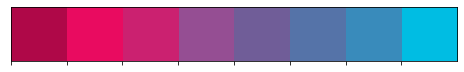

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import warnings
import glob
import gc
from wordcloud import WordCloud, STOPWORDS

plt.rcParams.update({'font.size': 16})

# Environment check
warnings.filterwarnings("ignore")

# Custom colors
class clr:
    S = '\033[1m' + '\033[95m'
    E = '\033[0m'
    
my_colors = ["#AF0848", "#E90B60", "#CB2170", "#954E93", "#705D98", "#5573A8", "#398BBB", "#00BDE3"]
print(clr.S+"Notebook Color Scheme:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

# bk_image = plt.imread("../input/hm-fashion-recommender-dataset/background.jpg")

In [3]:
data_dir = "./data/"
image_dir = '../data/images/*/*'

In [4]:
transactions = pd.read_csv(data_dir + 'transactions_train.csv', dtype={"t_dat": "object", "customer_id": "object", "article_id": "object", "price": float, "sales_channel_id": int})

In [5]:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
transactions['year'] = (transactions['t_dat'].dt.year-2000).astype('int8')
transactions['month'] = (transactions['t_dat'].dt.month).astype('int8')
transactions['day'] = (transactions['t_dat'].dt.day).astype('int8')
transactions.drop('t_dat', axis=1, inplace=True)
transactions['price'] = transactions['price'].astype('float32')
transactions['sales_channel_id'] = transactions['sales_channel_id'].astype('int8')
# transactions['article_id'] = transactions['article_id'].astype('int32')

In [6]:
articles = pd.read_csv(data_dir + 'articles.csv')

In [7]:
customers = pd.read_csv(data_dir + 'customers.csv')

In [8]:
id_to_index_dict = dict(zip(customers["customer_id"], customers.index))
index_to_id_dict = dict(zip(customers.index, customers["customer_id"]))
# for memory efficiency
transactions["customer_id"] = transactions["customer_id"].map(id_to_index_dict)
# transactions["customer_id"] = transactions["customer_id"].astype('int32')

**<span style="color:#023e8a;"> Let's look at the tables and try to get some outcomes about data inside.</span>**

Lets take a closer look at the data

There are 3 main tables:
- **articles** - contains informations about each article (like product code, name, product group code, name ...)    
- **customers** - contains informations about each customer (fidelity card membership, age, postal code)
- **transactions** (train)  

Transactions have `customer_id` and `article_id`, which are foreign keys for the customer and articles tables.
Beside this, transaction also contains `sales_channel_id`.

## **<span id="Articles" style="color:#023e8a;">2. Articles</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)


**<span style="color:#023e8a;"> This table contains all h&m articles with details such as a type of product, a color, a product group and other features.</span>**  
**<span style="color:#023e8a;"> Article data description: </span>**

> `article_id` **<span style="color:#023e8a;">: A unique identifier of every article.</span>**  
> `product_code`, `prod_name` **<span style="color:#023e8a;">: A unique identifier of every product and its name (not the same).</span>**  
> `product_type`, `product_type_name` **<span style="color:#023e8a;">: The group of product_code and its name</span>**  
> `graphical_appearance_no`, `graphical_appearance_name` **<span style="color:#023e8a;">: The group of graphics and its name</span>**  
> `colour_group_code`, `colour_group_name` **<span style="color:#023e8a;">: The group of color and its name</span>**  
> `perceived_colour_value_id`, `perceived_colour_value_name`, `perceived_colour_master_id`, `perceived_colour_master_name` **<span style="color:#023e8a;">: The added color info</span>**  
> `department_no`, `department_name`: **<span style="color:#023e8a;">: A unique identifier of every dep and its name</span>**  
> `index_code`, `index_name`: **<span style="color:#023e8a;">: A unique identifier of every index and its name</span>**  
> `index_group_no`, `index_group_name`: **<span style="color:#023e8a;">: A group of indeces and its name</span>**  
> `section_no`, `section_name`: **<span style="color:#023e8a;">: A unique identifier of every section and its name</span>**  
> `garment_group_no`, `garment_group_name`: **<span style="color:#023e8a;">: A unique identifier of every garment and its name</span>**  
> `detail_desc`: **<span style="color:#023e8a;">: Details</span>**  

## I. Preprocessing

🛍️ **Important Notes**:
* There are *more* `article_ids` than actual images:
    * unique article ids: 105,542
    * unique images: 105,100
* The `path` processing was taking too long, so the fastest (takes 1 second) way to do it was to create a variable that contains all article ids within the `images` folder (remember, `set()` is faster than a `list`), and then to correct any path that was invalid within the `articles.csv` file.
* There are only 416 missing values within the `desc` column - product description

In [9]:
print(clr.S+"ARTICLES:"+clr.E, articles.shape)
articles.head()

ARTICLES: (105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [10]:
print(clr.S+"There are no missing values in any columns but 'Detail Description':"+clr.E,
      articles.isna().sum()[-1], "total missing values")

# Replace missing values
articles.fillna(value="No Description", inplace=True)

# Adjust the article ID and product code to be string & add "0"
articles["article_id"] = articles["article_id"].apply(lambda x: adjust_id(x))
articles["product_code"] = articles["article_id"].apply(lambda x: x[:3])

There are no missing values in any columns but 'Detail Description': 416 total missing values


In [11]:
# Get all paths from the image folder
all_image_paths = glob.glob(image_dir)

print(clr.S+"Number of unique article_ids within articles.csv:"+clr.E, len(articles), "\n"+
      clr.S+"Number of unique images within the image folder:"+clr.E, len(all_image_paths), "\n"+
      clr.S+"=> not all article_ids have a corresponding image!!!"+clr.E, "\n")

# Get all valid article ids
# Create a set() - as it moves faster than a list
all_image_ids = set()

for path in tqdm(all_image_paths):
    article_id = path.split('/')[-1].split('.')[0]
    all_image_ids.add(article_id)

Number of unique article_ids within articles.csv: 105542 
Number of unique images within the image folder: 0 
=> not all article_ids have a corresponding image!!! 



0it [00:00, ?it/s]

## II. Explore

**<span style="color:#023e8a;">Ladieswear accounts for a significant part of all dresses. Sportswear has the least portion.</span>**

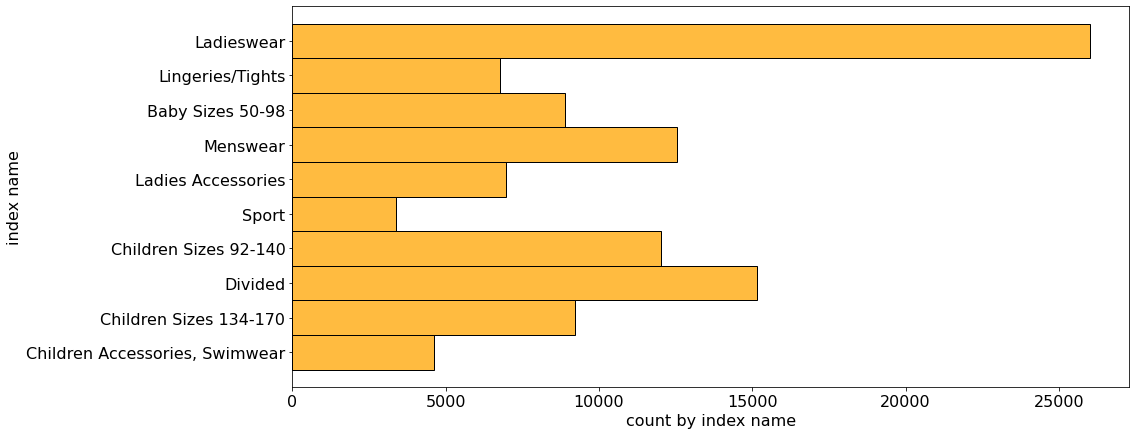

In [12]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='index_name', color='orange')
ax.set_xlabel('count by index name')
ax.set_ylabel('index name')
plt.show()

**<span style="color:#023e8a;"> The garments grouped by index: Jersey fancy is the most frequent garment, especially for women and children. The next by number is accessories, many various accessories with low price.</span>**

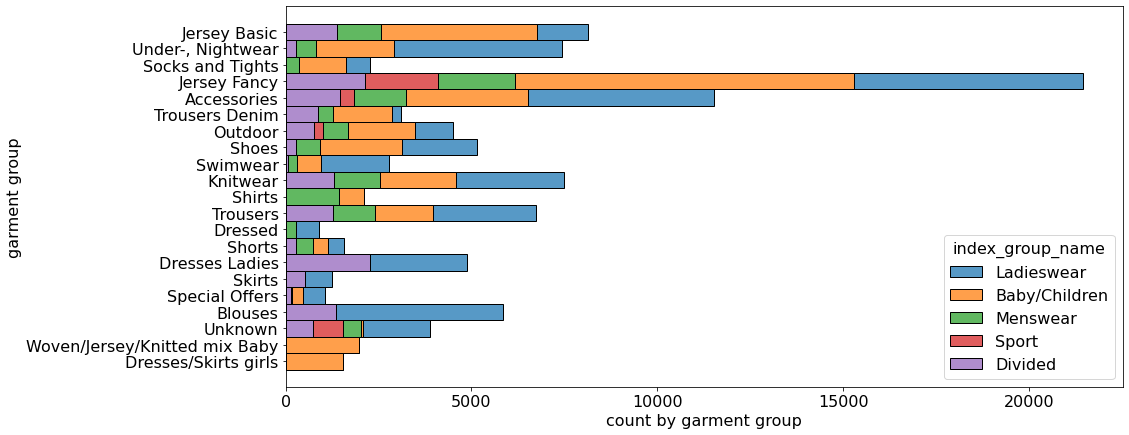

In [13]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='garment_group_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by garment group')
ax.set_ylabel('garment group')
plt.show()


**<span style="color:#023e8a;">Most sold product is the Dragonfly dress.</span>**

Total Number of unique Product Names: 45875


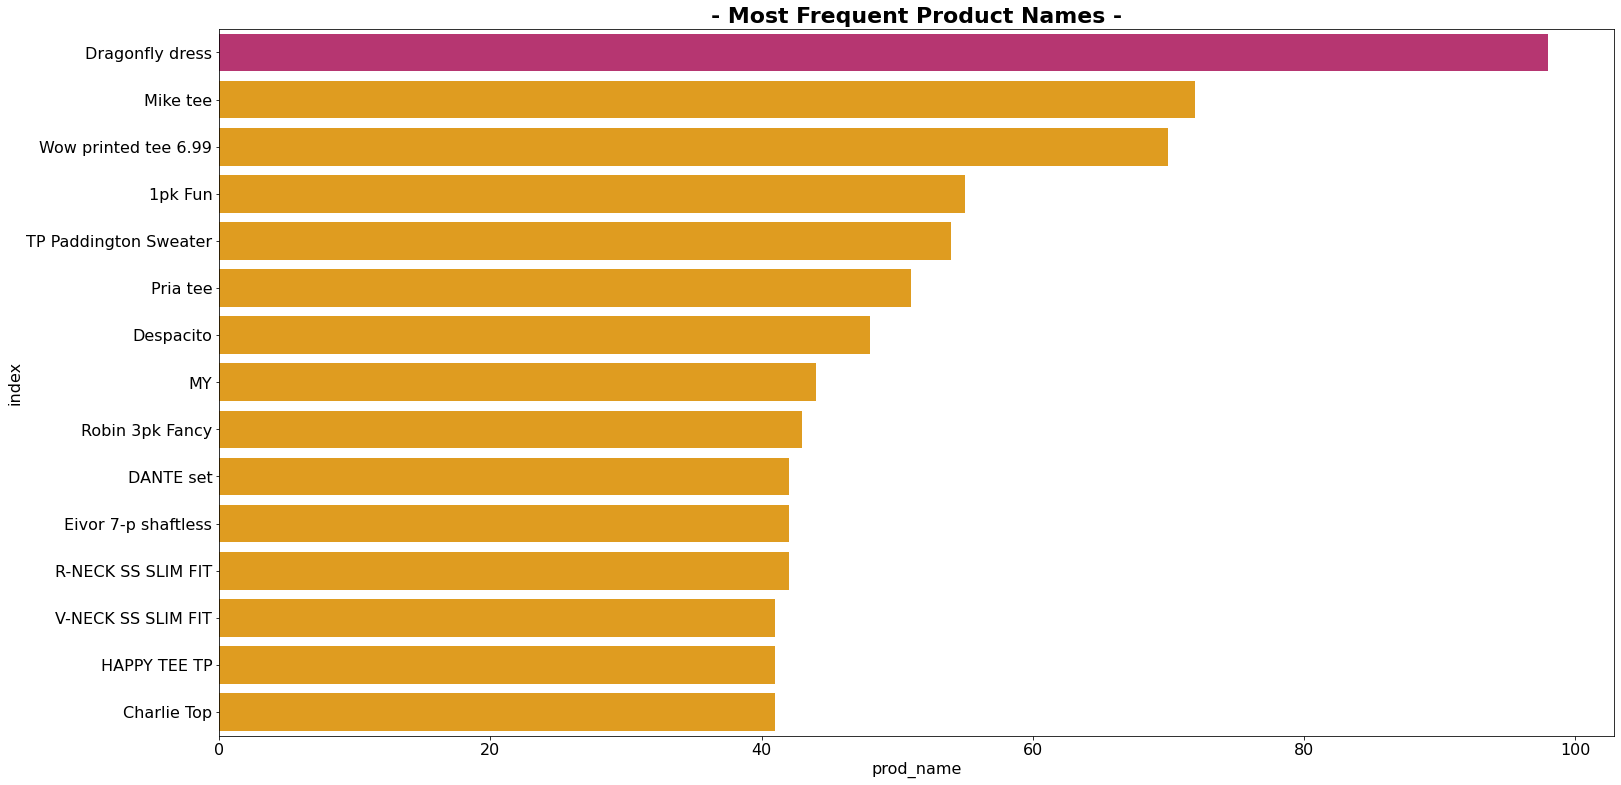

In [14]:
print(clr.S+"Total Number of unique Product Names:"+clr.E, articles["prod_name"].nunique())

# Data
prod_name = articles["prod_name"].value_counts().reset_index().head(15)
total_prod_names = articles["prod_name"].nunique()
clrs = ["#CB2170" if x==max(prod_name["prod_name"]) else '#FFA500' for x in prod_name["prod_name"]]

# Plot
fig, ax = plt.subplots(figsize=(25, 13))
plt.title('- Most Frequent Product Names -', size=22, weight="bold")
sns.barplot(data=prod_name, x="prod_name", y="index", ax=ax,
            palette=clrs)
plt.show()

**<span style="color:#023e8a;">Now, pay attention to index group-index structure. Ladieswear and Children/Baby have subgroups.</span>**

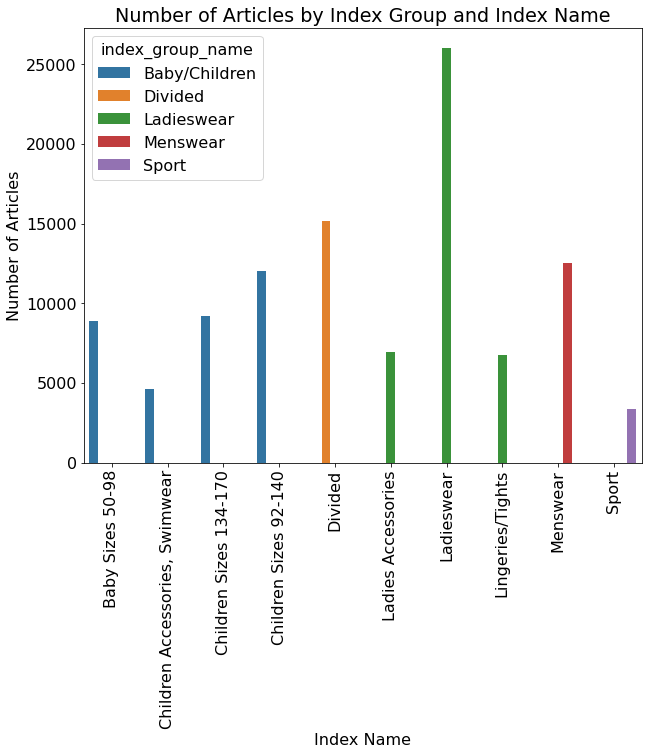

In [15]:
# articles.groupby(['index_group_name', 'index_name']).count()['article_id# create a DataFrame from the groupby object
temp_group = articles.groupby(['index_group_name', 'index_name']).count()['article_id'].reset_index()

# create the barplot
plt.figure(figsize=(10, 8))
sns.barplot(x='index_name', y='article_id', hue='index_group_name', data=temp_group)
plt.title('Number of Articles by Index Group and Index Name')
plt.xlabel('Index Name')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.show()

**<span style="color:#023e8a;"> And look at the product group-product structure. Accessories are really various, the most numerious: bags, earrings and hats. However, trousers prevail.</span>**

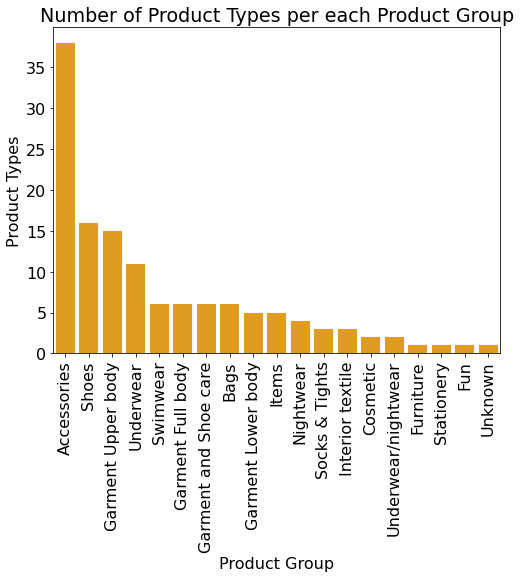

In [16]:
temp = articles.groupby(["product_group_name"])["product_type_name"].nunique()
df = pd.DataFrame({'Product Group': temp.index,
                   'Product Types': temp.values
                  })
df = df.sort_values(['Product Types'], ascending=False)
plt.figure(figsize = (8,6))
plt.title('Number of Product Types per each Product Group')
sns.set_color_codes("pastel")
s = sns.barplot(x = 'Product Group', y="Product Types", data=df, color='orange')
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

In [17]:
# create a list of dictionaries, where each dictionary contains the column name and its number of unique values
unique_values = []
for col in articles.columns:
    if not 'no' in col and not 'code' in col and not 'id' in col:
        un_n = articles[col].nunique()
        unique_values.append({'Column Name': col, 'Number of Unique Values': un_n})

# create a pandas DataFrame from the list of dictionaries
df_unique_values = pd.DataFrame(unique_values)
# display the DataFrame
display(df_unique_values)

,Column Name,Number of Unique Values
0,prod_name,45875
1,product_type_name,131
2,product_group_name,19
3,graphical_appearance_name,30
4,colour_group_name,50
5,perceived_colour_value_name,8
6,perceived_colour_master_name,20
7,department_name,250
8,index_name,10
9,index_group_name,5



**<span style="color:#023e8a;"> And look at the product type structure. Trousers are the most sold product type followed by dress and sweater.</span>**

Total Number of unique Product Types: 131


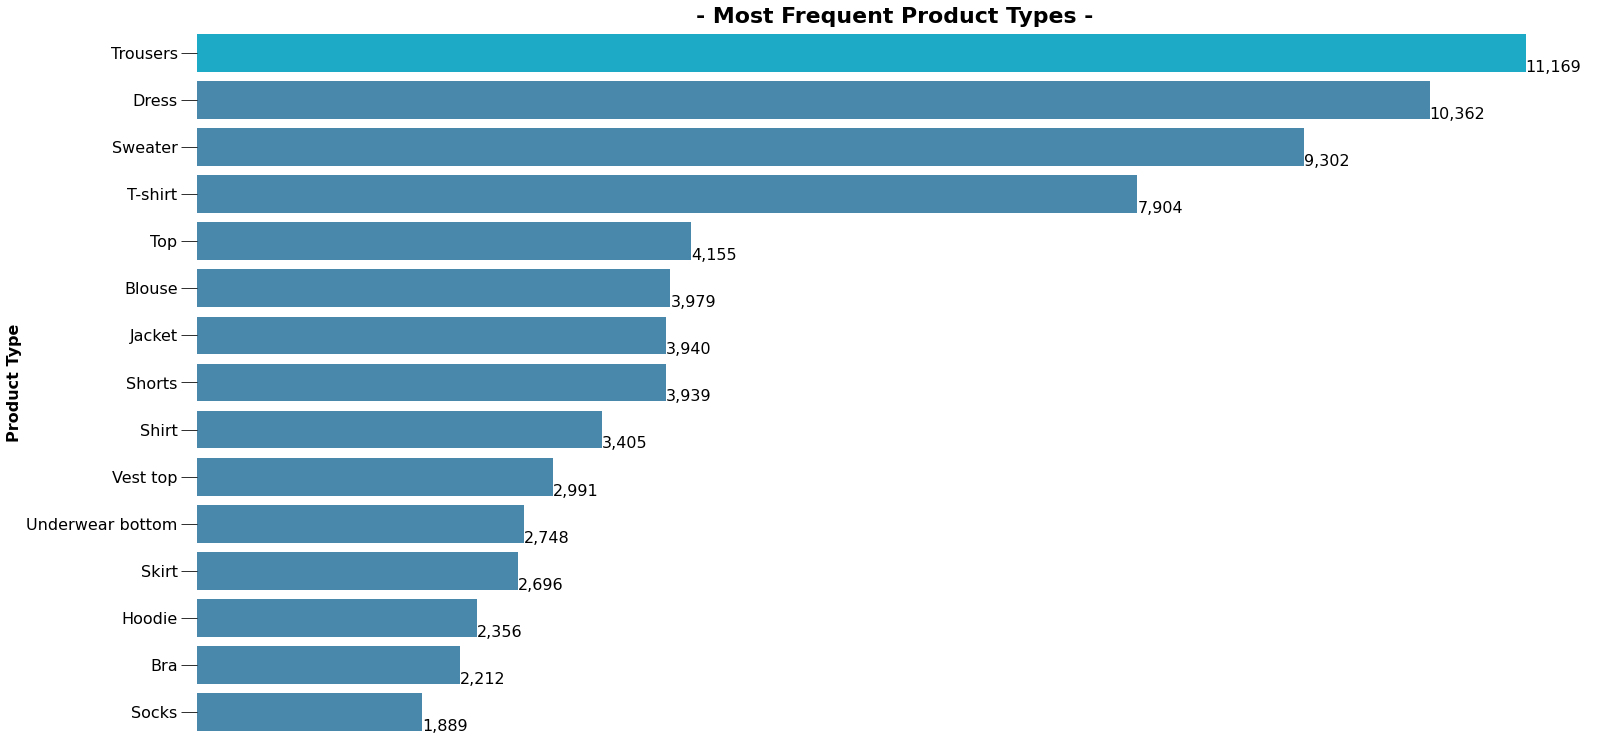

In [18]:
print(clr.S+"Total Number of unique Product Types:"+clr.E, articles["product_type_name"].nunique())

# Data
prod_type = articles["product_type_name"].value_counts().reset_index().head(15)
total_prod_types = articles["product_type_name"].nunique()
clrs = ["#00BDE3" if x==max(prod_type["product_type_name"]) else '#398BBB' for x in prod_type["product_type_name"]]


# Plot
fig, ax = plt.subplots(figsize=(25, 13))
plt.title('- Most Frequent Product Types -', size=22, weight="bold")

sns.barplot(data=prod_type, x="product_type_name", y="index", ax=ax,
            palette=clrs)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()

show_values_on_bars(axs=ax, h_v="h", space=0.4)
plt.ylabel("Product Type", size = 16, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)
plt.tick_params(size=16)

sns.despine(left=True, bottom=True)
plt.show();

print("\n")

**<span style="color:#023e8a;"> We can again see the upper garment are very popular.</span>**

Total Number of unique Product Group: 19


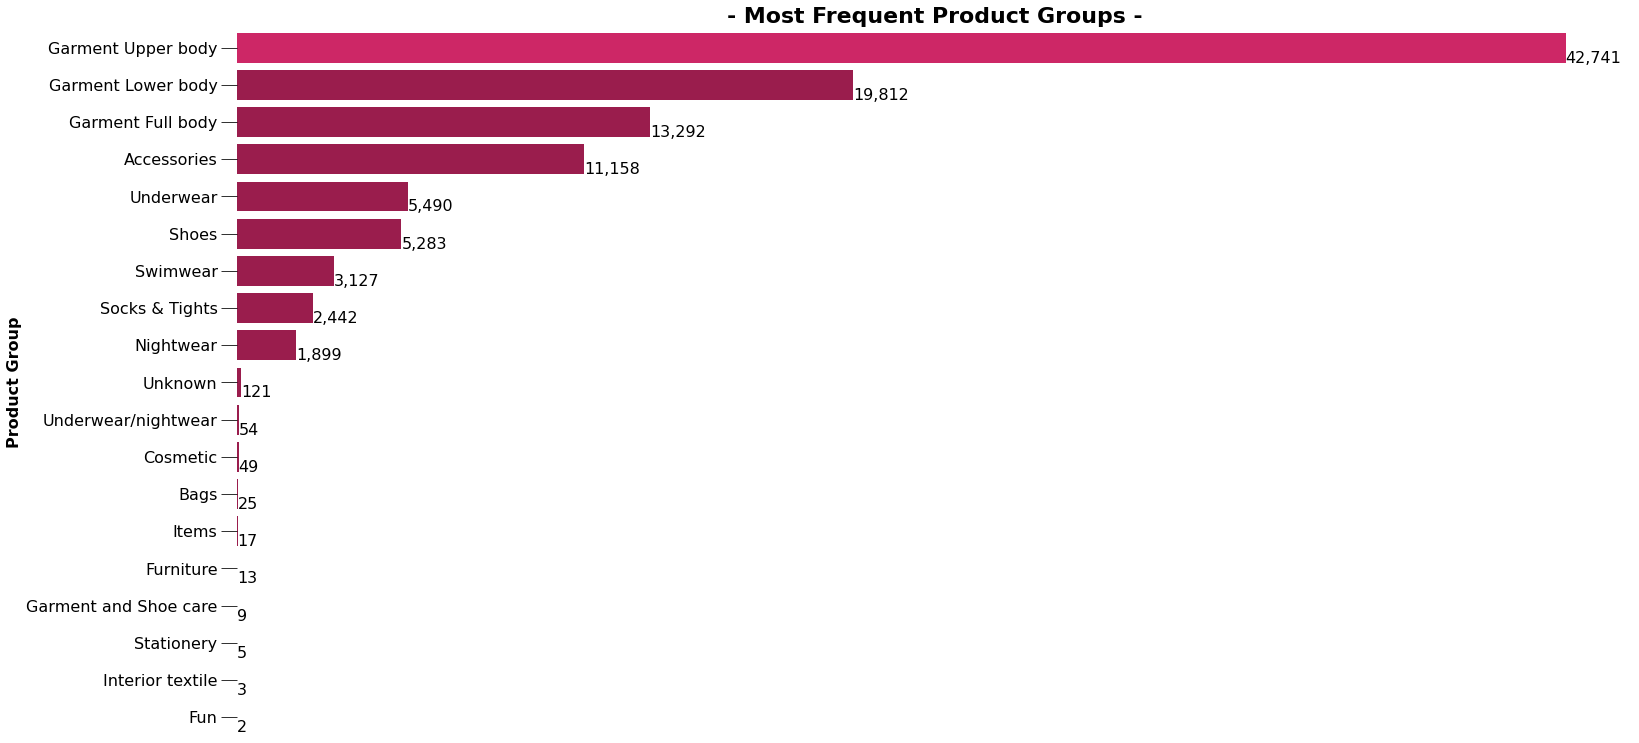

In [19]:
print(clr.S+"Total Number of unique Product Group:"+clr.E, articles["product_group_name"].nunique())

# Data
prod_group = articles["product_group_name"].value_counts().reset_index()
total_prod_groups = articles["product_group_name"].nunique()
clrs = ["#E90B60" if x==max(prod_group["product_group_name"]) else '#AF0848' for x in prod_group["product_group_name"]]

# Plot
fig, ax = plt.subplots(figsize=(25, 13))
plt.title('- Most Frequent Product Groups -', size=22, weight="bold")

sns.barplot(data=prod_group, x="product_group_name", y="index", ax=ax,
            palette=clrs)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()

show_values_on_bars(axs=ax, h_v="h", space=0.4)
plt.ylabel("Product Group", size = 16, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)
plt.tick_params(size=16)

sns.despine(left=True, bottom=True)
plt.show();

In [20]:
def change_color(x):
    '''Change color name.'''
    if ("light" in x.lower().strip()) or \
        ("dark" in x.lower().strip()) or \
        ("greyish" in x.lower().strip()) or \
        ("yellowish" in x.lower().strip()) or \
        ("greenish" in x.lower().strip()) or \
        ("off" in x.lower().strip()) or \
        ("other" in x.lower().strip()):
        x = x.split(" ")[-1]
        
    return x

articles["colour_group_name"] = articles["colour_group_name"].apply(lambda x: change_color(x))

Total Number of unique Product Appearances: 30
Total Number of unique Product Colors (after preprocess): 20


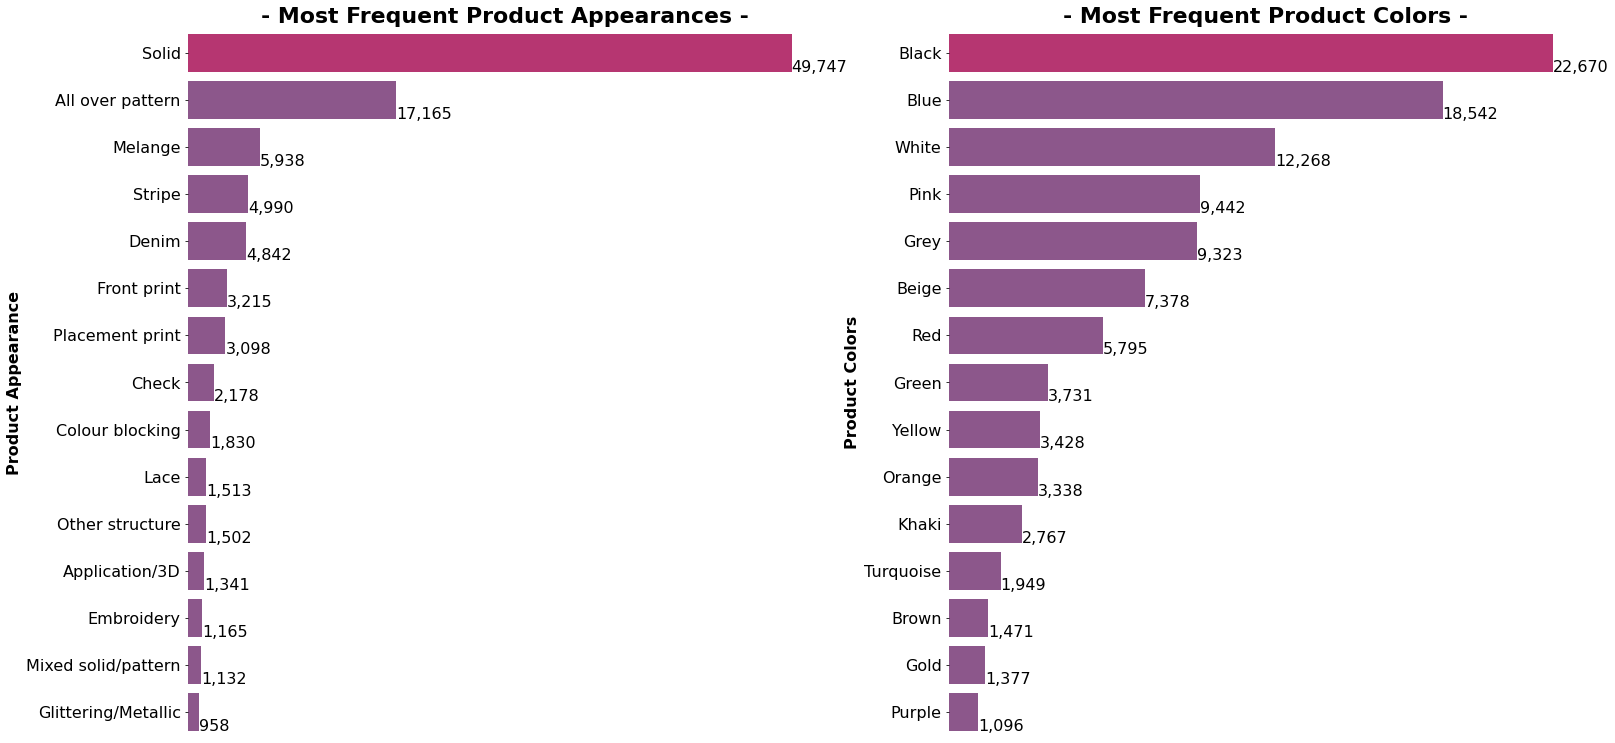

In [21]:
# Appearance and color
print(clr.S+"Total Number of unique Product Appearances:"+clr.E, articles["graphical_appearance_name"].nunique())
print(clr.S+"Total Number of unique Product Colors (after preprocess):"+clr.E, articles["colour_group_name"].nunique())

# --- Data 1 ---
prod_appearance = articles["graphical_appearance_name"].value_counts().reset_index().head(15)
total_prod_appearances = articles["graphical_appearance_name"].nunique()
clrs1 = ["#AF0848" if x==max(prod_appearance["graphical_appearance_name"]) else '#E90B60' for x in prod_appearance["graphical_appearance_name"]]

# --- Data 2 ---
prod_color = articles["colour_group_name"].value_counts().reset_index().head(15)
total_prod_color = articles["colour_group_name"].nunique()
clrs2 = ["#CB2170" if x==max(prod_color["colour_group_name"]) else '#954E93' for x in prod_color["colour_group_name"]]

# Plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 13))

ax1.set_title('- Most Frequent Product Appearances -', size=22, weight="bold")
sns.barplot(data=prod_appearance, x="graphical_appearance_name", y="index", ax=ax1,
            palette=clrs2)
x0,x1 = ax1.get_xlim()
y0,y1 = ax1.get_ylim()

show_values_on_bars(axs=ax1, h_v="h", space=0.4)

ax1.set_ylabel("Product Appearance", size = 16, weight="bold")
ax1.set_xlabel("")
ax1.set_xticks([])

ax2.set_title('- Most Frequent Product Colors -', size=22, weight="bold")
sns.barplot(data=prod_color, x="colour_group_name", y="index", ax=ax2,
            palette=clrs2)
x0,x1 = ax2.get_xlim()
y0,y1 = ax2.get_ylim()

show_values_on_bars(axs=ax2, h_v="h", space=0.4)
ax2.set_ylabel("Product Colors", size = 16, weight="bold")
ax2.set_xlabel("")
ax2.set_xticks([])

sns.despine(left=True, bottom=True)
plt.show();

print("\n")

---

🛍️ **Important Notes**:
* In order for the wordcloud to take the shape of the image you should input a `.jpg` image with **white** background (not black and not transparent - because the function will interpret the transparent background as black).
* More custom fonts like I used below can be found here: https://www.dafont.com/

In [22]:
def similar_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    '''Creates a custom function for the color of the wordcloud.'''
    
    h = 270 # 0 - 360 <- the color hue
    s = 40 # 0-100 <- the color saturation
    l = random_state.randint(30, 70) # 0 - 100 <- gradient
    
    return "hsl({}, {}%, {}%)".format(h, s, l)

Total Number of unique Article Descriptions: 43405 



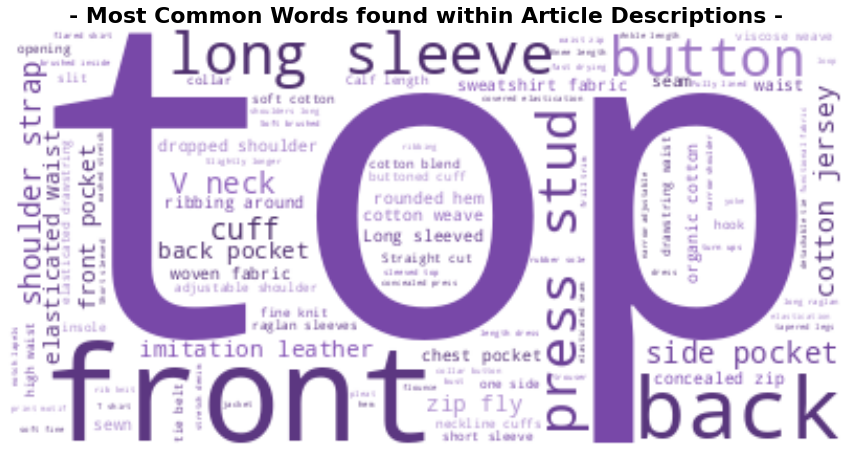

In [23]:
print(clr.S+"Total Number of unique Article Descriptions:"+clr.E, articles["detail_desc"].nunique(), "\n")

# Get descriptions and convert them to a string
text = articles["detail_desc"].unique()
text = " ".join(text)

# Get the mask - the form of the wordcloud
# mask = np.array(Image.open('../input/hm-fashion-recommender-dataset/pics/mask.jpg'))

# Create wordcloud object
wc = WordCloud(background_color="white", max_words=2000,
               stopwords=STOPWORDS, max_font_size=256,
               random_state=42,
               color_func=similar_color_func)
wc.generate(text)

# Plot
fig = plt.figure(figsize=(15, 15))
plt.title("- Most Common Words found within Article Descriptions -",
           size=22, weight="bold")
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

## **<span id="Customers" style="color:#023e8a;">3. Customers</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)

**<span style="color:#023e8a;"> Customers data description: </span>**

> `customer_id` **<span style="color:#023e8a;">: A unique identifier of every customer</span>**  
> `FN` **<span style="color:#023e8a;">: 1 or missed </span>**  
> `Active` **<span style="color:#023e8a;">: 1 or missed</span>**  
> `club_member_status` **<span style="color:#023e8a;">: Status in club</span>**  
> `fashion_news_frequency` **<span style="color:#023e8a;">: How often H&M may send news to customer</span>**  
> `age` **<span style="color:#023e8a;">: The current age</span>**  
> `postal_code` **<span style="color:#023e8a;">: Postal code of customer</span>**  

🛍️ **Important Notes**:
* In this dataset we have quite a few missing values:
    * for columns `FN` and `Active` I replaced all missing values with 0
    * for `club_member_status` and `fashion_news_frequency` I have set all missing values with `UNKNOWN`
    * for `age` I have imputed all missing values with the median age (which is 36)
* I have created an `age_interval` as well that splits all ages in decades

In [24]:
def create_age_interval(x):
    if x <= 25:
        return [16, 25]
    elif x <= 35:
        return [26, 35]
    elif x <= 45:
        return [36, 45]
    elif x <= 55:
        return [46, 55]
    elif x <= 65:
        return [56, 65]
    else:
        return [66, 99]

In [25]:
print(clr.S+"Missing values within customers dataset:"+clr.E)
print(customers.isna().sum())

# Fill FN and Active - the only available value is "1"
customers["FN"].fillna(0, inplace=True)
customers["Active"].fillna(0, inplace=True)

# Set unknown the club member status & news frequency
customers["club_member_status"].fillna("UNKNOWN", inplace=True)

customers["fashion_news_frequency"] = customers["fashion_news_frequency"].replace({"None":"NONE"})
customers["fashion_news_frequency"].fillna("UNKNOWN", inplace=True)

# Set missing values in age with the median
customers["age"].fillna(customers["age"].median(), inplace=True)
customers["age_interval"] = customers["age"].apply(lambda x: create_age_interval(x))

Missing values within customers dataset:
customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64


In [26]:
pd.options.display.max_rows = 50
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_interval
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,"[46, 55]"
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,"[16, 25]"
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"[16, 25]"
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,"[46, 55]"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,"[46, 55]"


**<span style="color:#023e8a;"> There are no duplicates in </span>** `customers`

In [27]:
customers.shape[0] - customers['customer_id'].nunique()

0

**<span style="color:#023e8a;"> Here we have abnormal number of customers by one postal code. One has 120303, it might be encoded nan adress or smth like a huge distribution center, or pickup.</span>**

In [28]:
data_postal = customers.groupby('postal_code', as_index=False).count().sort_values('customer_id', ascending=False)
data_postal.head()

,postal_code,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,age_interval
61034,2c29ae653a9282cce4151bd87643c907644e09541abc28...,120303,120303,120303,120303,120303,120303,120303
281937,cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac...,261,261,261,261,261,261,261
156090,714976379549eb90aae4a71bca6c7402cc646ae7c40f6c...,159,159,159,159,159,159,159
171208,7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5...,157,157,157,157,157,157,157
126228,5b7eb31eabebd3277de632b82267286d847fd5d44287ee...,156,156,156,156,156,156,156


**<span style="color:#023e8a;"> Ages, club_member_status are different, like customer_ids.</span>**

In [29]:
customers[customers['postal_code']=='2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c'].head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_interval
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,0.0,0.0,UNKNOWN,UNKNOWN,32.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...,"[26, 35]"
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,0.0,0.0,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...,"[16, 25]"
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,0.0,0.0,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...,"[16, 25]"
11,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,0.0,0.0,ACTIVE,NONE,31.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...,"[26, 35]"
14,0000ae1bbb25e04bdc7e35f718e852adfb3fbb72ef38b3...,1.0,1.0,ACTIVE,Regularly,29.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...,"[26, 35]"


**<span style="color:#023e8a;"> The most common age is about 21-23</span>**

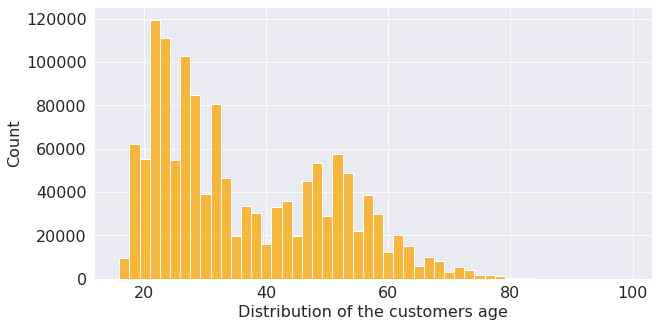

In [30]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customers, x='age', bins=50, color='orange')
ax.set_xlabel('Distribution of the customers age')
plt.show()

**<span style="color:#023e8a;"> Status in H&M club. Almost every customer has an active club status, some of them begin to activate it (pre-create). A tiny part of customers abandoned the club.</span>**

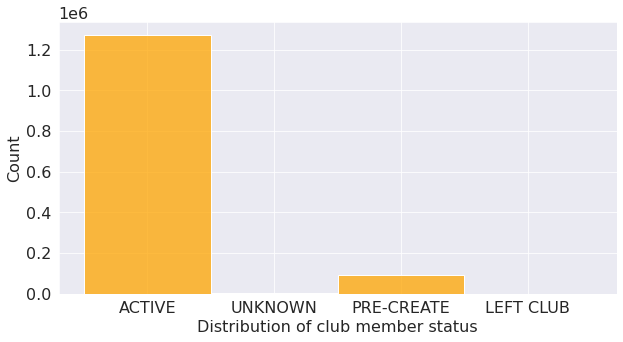

In [31]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customers, x='club_member_status', color='orange')
ax.set_xlabel('Distribution of club member status')
plt.show()

**<span style="color:#023e8a;"> Here we have three types for NO DATA. Let's unite these values.</span>**

In [32]:
customers['fashion_news_frequency'].unique()

array(['NONE', 'Regularly', 'UNKNOWN', 'Monthly'], dtype=object)

In [33]:
customers.loc[~customers['fashion_news_frequency'].isin(['Regularly', 'Monthly']), 'fashion_news_frequency'] = 'None'
customers['fashion_news_frequency'].unique()

array(['None', 'Regularly', 'Monthly'], dtype=object)

In [34]:
pie_data = customers[['customer_id', 'fashion_news_frequency']].groupby('fashion_news_frequency').count()

**<span style="color:#023e8a;"> Customers prefer not to get any messages about the current news.</span>**

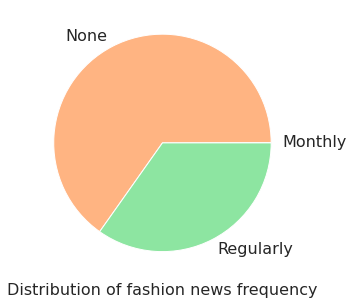

In [35]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
# ax = sns.histplot(data=customers, x='fashion_news_frequency', color='orange')
# ax = sns.pie(data=customers, x='fashion_news_frequency', color='orange')
colors = sns.color_palette('pastel')
ax.pie(pie_data.customer_id, labels=pie_data.index, colors = colors)
ax.set_facecolor('lightgrey')
ax.set_xlabel('Distribution of fashion news frequency')
plt.show()

## **<span id="Transactions" style="color:#023e8a;">4. Transactions</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)

**<span style="color:#023e8a;"> Transactions data description: </span>**

> `t_dat` **<span style="color:#023e8a;">: A unique identifier of every customer</span>**  
> `customer_id` **<span style="color:#023e8a;">: A unique identifier of every customer </span>**  **<span style="color:#FF0000;">(in </span>** `customers` **<span style="color:#FF0000;"> table)</span>**  
> `article_id` **<span style="color:#023e8a;">: A unique identifier of every article</span>**  **<span style="color:#FF0000;">(in </span>** `articles` **<span style="color:#FF0000;"> table)</span>**  
> `price` **<span style="color:#023e8a;">: Price of purchase</span>**  
> `sales_channel_id` **<span style="color:#023e8a;">: 1 or 2</span>**  

🛍️ **Important Notes**:
* Denims, Trousers and Undergarments are sold the most.
* The **prices are altered**, with the highest one being 0.59 and the lowest being 0.0000169.
* The most expensive items are leather garments.
* The average order has around 23 units and costs ~0.649.
* The units/order is directly correlated with the price/order: as the units increase, the price within the order increases too.

In [36]:
print(clr.S+"Missing values within transactions dataset:"+clr.E)
print(transactions.isna().sum())

Missing values within transactions dataset:
customer_id         0
article_id          0
price               0
sales_channel_id    0
year                0
month               0
day                 0
dtype: int64


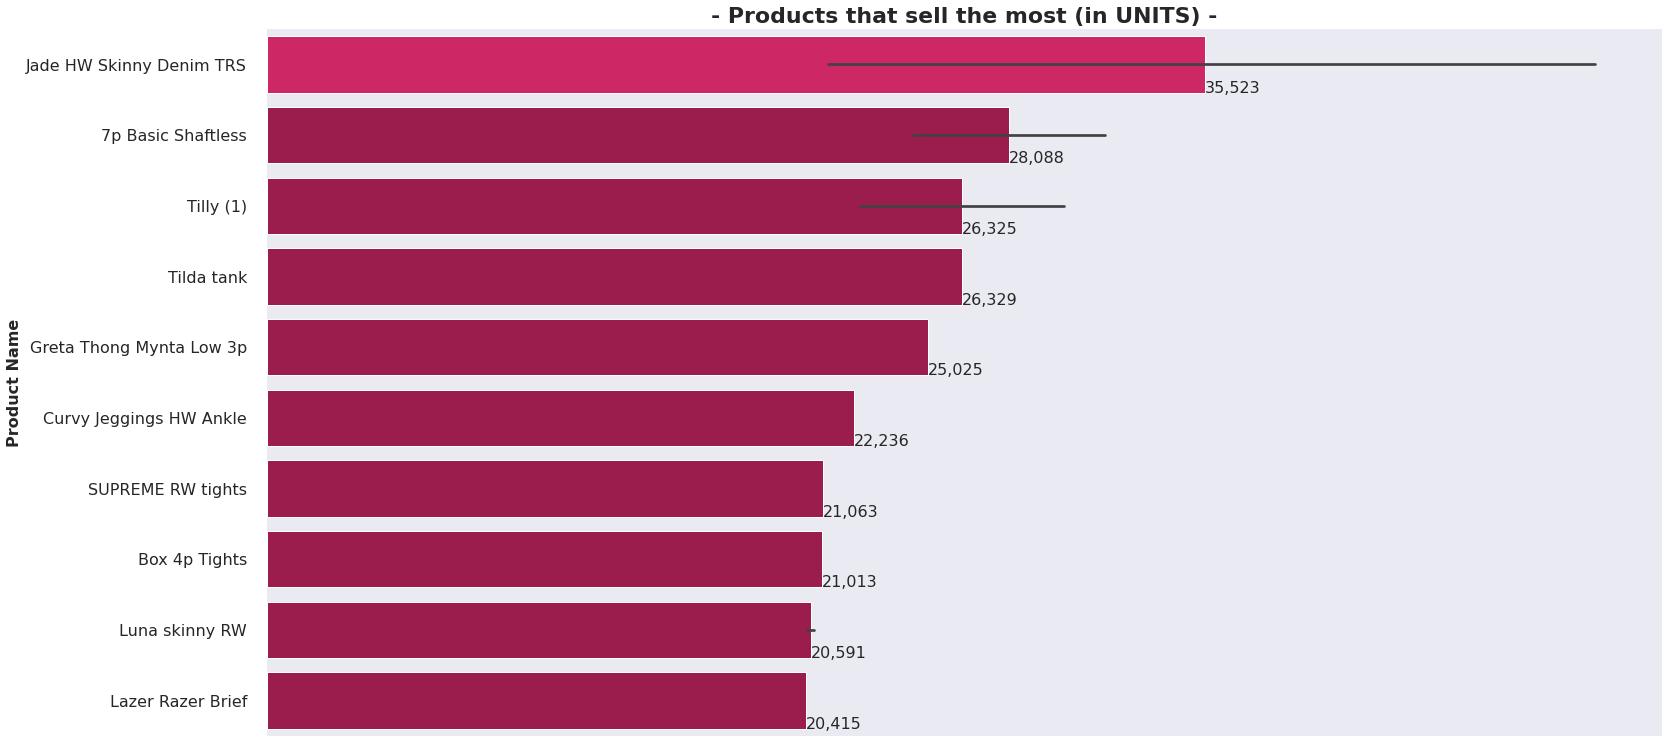

In [37]:
# Get data
top_sold_products = transactions["article_id"].value_counts().reset_index().head(15)
top_sold_products.columns = ["article_id", "count"]
top_sold_products = pd.merge(top_sold_products, articles, on="article_id")[["article_id", "count", "prod_name"]]

clrs = ["#E90B60" if x==max(top_sold_products["count"]) else '#AF0848' for x in top_sold_products["count"]]
# Plot
fig, ax = plt.subplots(figsize=(25, 13))
plt.title('- Products that sell the most (in UNITS) -', size=22, weight="bold")

sns.barplot(data=top_sold_products, x="count", y="prod_name", ax=ax,
            palette=clrs)

show_values_on_bars(axs=ax, h_v="h", space=0.4)
plt.ylabel("Product Name", size = 16, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)
plt.tick_params(size=16)

sns.despine(left=True, bottom=True)
plt.show();

In [38]:
print(clr.S+"Maximum Price is:"+clr.E, transactions["price"].max(), "\n" +
      clr.S+"Minimum Price is:"+clr.E, transactions["price"].min(), "\n" +
      clr.S+"Average Price is:"+clr.E, transactions["price"].mean())

# Get data
top_sold_products = transactions.groupby("article_id")["price"].max().reset_index()\
                                        .sort_values("price", ascending=False).head(15)
top_sold_products.columns = ["article_id", "price"]
top_sold_products = pd.merge(top_sold_products, articles, on="article_id")[["article_id", "price", "prod_name"]]
print(clr.S + "Most Expensive products:" + clr.E)
display(top_sold_products)

Maximum Price is: 0.5915254354476929 
Minimum Price is: 1.694915226835292e-05 
Average Price is: 0.027829282
Most Expensive products:


,article_id,price,prod_name
0,0697511001,0.591525,PE LINDA LEATHER COAT
1,0839478001,0.506780,PQ SUSAN LEATHER TUNIC
2,0653551001,0.506780,Benji leather jacket
3,0797432001,0.506780,CEMENT leather jacket
4,0810872001,0.506780,PQ AGDA LEATHER DRESS
5,0613539001,0.506780,CE Ivy lace dress
6,0916300001,0.506780,PQ OLGA LEATHER DRESS
7,0713219001,0.506780,LEMON Shearling Jacket 1
8,0916300002,0.506780,PQ OLGA LEATHER DRESS
9,0805760001,0.506780,LEMON shearling jacket


=== UNITS/ORDER ===
Maximum Units/Order is: 1895 
Minimum Units/Order is: 1 
Average Units/Order is: 23.334630667241193 

=== SPENDING/ORDER ===
Maximum Spending/Order is: 57.67640686035156 
Minimum Spending/Order is: 0.0007627118611708283 
Average Spending/Order is: 0.64938575


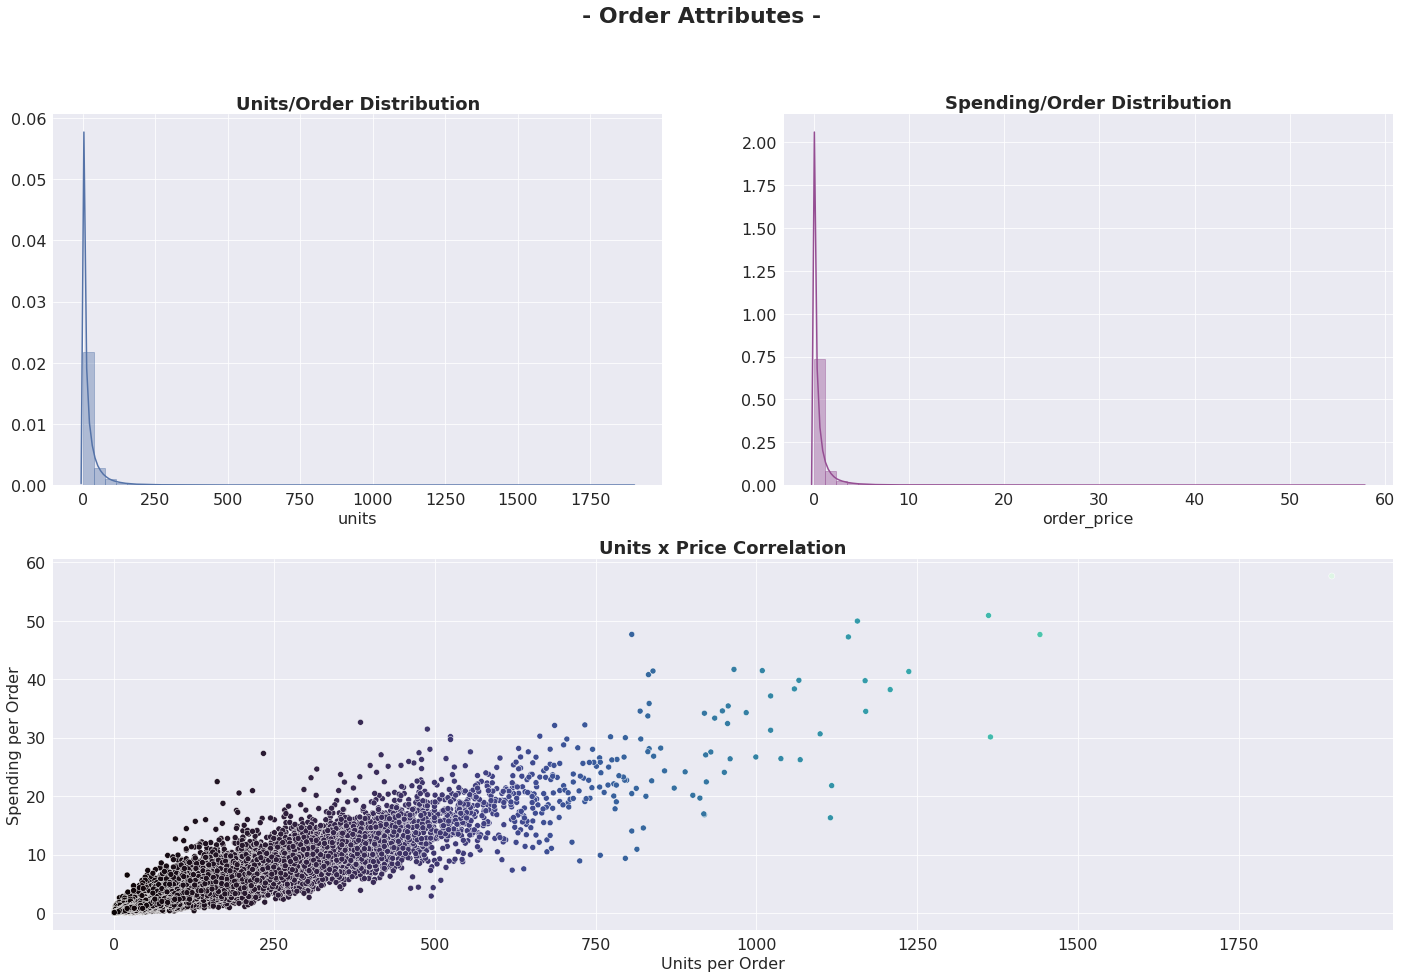

In [39]:
# Data
basket = transactions.groupby("customer_id").agg({'article_id':'count', 
                                                  'price': 'sum'}).reset_index()
basket.columns = ["customer_id", "units", "order_price"]

print(clr.S+"=== UNITS/ORDER ==="+clr.E)
print(clr.S+"Maximum Units/Order is:"+clr.E, basket["units"].max(), "\n" +
      clr.S+"Minimum Units/Order is:"+clr.E, basket["units"].min(), "\n" +
      clr.S+"Average Units/Order is:"+clr.E, basket["units"].mean(), "\n")

print(clr.S+"=== SPENDING/ORDER ==="+clr.E)
print(clr.S+"Maximum Spending/Order is:"+clr.E, basket["order_price"].max(), "\n" +
      clr.S+"Minimum Spending/Order is:"+clr.E, basket["order_price"].min(), "\n" +
      clr.S+"Average Spending/Order is:"+clr.E, basket["order_price"].mean())

# Plot
plt.figure(figsize=(24, 15))
plt.suptitle('- Order Attributes -', size=22, weight="bold")

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

sns.distplot(basket["units"], color=my_colors[-3], ax=ax1,
             hist_kws=dict(edgecolor=my_colors[-3]))
ax1.set_title("Units/Order Distribution", size=18, weight="bold")
ax1.set_ylabel("")

sns.distplot(basket["order_price"], color=my_colors[-5], ax=ax2,
             hist_kws=dict(edgecolor=my_colors[-5]))
ax2.set_title("Spending/Order Distribution", size=18, weight="bold")
ax2.set_ylabel("")

sns.scatterplot(data=basket, x="units", y="order_price", hue="units", palette="mako", 
                legend=None, ax=ax3)
ax3.set_title("Units x Price Correlation", size=18, weight="bold")
ax3.set_ylabel("Spending per Order")
ax3.set_xlabel("Units per Order")

sns.despine(left=True, bottom=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None);

In [42]:
del articles, customers, transactions
del top_sold_products, prod_appearance, prod_color, prod_name
gc.collect()

NameError: name 'articles' is not defined

<img src="https://i.imgur.com/nMuocgz.png">

# 5. Market Basket Analysis

**What is a Recommender System**?

A recommender system is not more or less than an algorithm that tries to predict the preference on an object or concept based on somebody's preferences for other objects or concepts.

This can apply to **anything**: movies, songs, books, amazon orders, clothing or just Google Engine searches.

<center><img src="https://i.imgur.com/m8T6MhL.png" width=500></center>

<!-- > 🛍 **Turicreate**: we will be using `turicreate` model in order to create recommendations for users based on their previous purchases. For more details about the library you can [read the documentation](https://github.com/apple/turicreate). My main inspiration was this amazing article [How to Build a Recommendation System for Purchase Data (Step-by-Step)](https://medium.datadriveninvestor.com/how-to-build-a-recommendation-system-for-purchase-data-step-by-step-d6d7a78800b6). -->

> 🛍 **RAPIDS**: as RAPIDS outperformes pandas whenever we have large datasets, I will be using it to prepare the data.

In [45]:
def create_predictions_format(data):
    '''
    data: a pandas dataframe that contains customer_id and article_id columns
            that we wish to format as in submission file
    return: data[["customer_id", "preds"]]
    '''
    
    # Adjust ID
    data["article_id"] = data["article_id"].apply(lambda x: adjust_id(x))

    # Group article_ids
    all_preds = data.groupby("customer_id")["article_id"].unique().to_dict()
    data["preds"] = data["customer_id"].map(all_preds)
    data["preds"] = data["preds"].apply(lambda x: " ".join([str(y) for y in x]))

    # Unicize
    data = data.groupby("customer_id")["preds"].first().reset_index()
    
    return data


def get_frequent_purchases(transactions, n=50):
    '''
    This function looks at customer level and retrieves most frequent (> 50%) purchased items
    transactions: original cudf .csv or .pqt file
    return : temp[["customer_id", "preds"]]
    '''
    
    # Compute count per each customer and article
    temp = transactions.groupby(["customer_id", "article_id"])["t_dat"].count().reset_index()
    temp.columns = ["customer_id", "article_id", "count"]

    # Compute total count per each customer
    temp2 = transactions.groupby(["customer_id"])["t_dat"].count().reset_index()
    temp2.columns = ["customer_id", "full_count"]

    temp = temp.merge(temp2, on="customer_id", how="left")
    temp["perc"] = (temp["count"] / temp["full_count"])*100

    # Select only articles that represented at least 50% of the entire purchase
    temp = temp[temp["perc"] >= n].reset_index(drop=True).to_pandas()

    temp = create_predictions_format(temp)

    return  cudf.DataFrame(temp)